In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Overview

### Objective
* To determine the different tier ranking for NBA players based on their advanced stats using. Since we don't know the teirs for the players we will you supervised learning to classify them.

### Dataset Source
* https://basketball.realgm.com/
* Data was scraped using BeatifulSoup and saved to CSV files. Please reference ./utils/nba_webscrapper.py for more details.

### Dataset Column Descriptions:
* https://basketball.realgm.com/info/glossary

#### Main Features
* PER: An efficiency statistic created by John Hollinger. Click here for more information.
* FIC (Floor Impact Counter): A formula to encompass all aspects of the box score into a single statistic. The intent of the statistic is similar to other efficiency stats, but assists, shot creation and offensive rebounding are given greater importance. Created by Chris Reina in 2007.
    * Formula: (Points + ORB. + 0.75 DRB + AST + STL + BLK –0.75 FGA – 0.375 FTA – TO – 0.5 PF)
* MPG: Meadian number of minutes per game.
* GP: Median games played.
* All Star: The number of all star appearances

In [2]:
all_star_df = pd.read_csv("./data/nba_tiers/all_star_data.csv", index_col=0).drop("selection_yrs", axis=1)
all_star_df = all_star_df.T.to_dict()

In [3]:
nba_avgs_df = pd.read_csv("./data/nba_tiers/player_Averages_stats_2010-2022.csv").drop("Rank", axis=1)

# Because we have multiple seasons, we will calculate a players career median. We chose median because
# players can have outlier seasons or a great 5 years, but then decline as they get older.
nba_adv_df = pd.read_csv("./data/nba_tiers/player_Advanced_Stats_stats_2010-2022.csv", na_values="-").drop(["Rank", "Year"], axis=1)
nba_adv_df["FIC"]= nba_adv_df["FIC"].str.replace(",", "").astype(float) # remove commas and conver to ints
nba_adv_df = nba_adv_df.groupby("Player", as_index=False).median()

# For the averages we will only care about GP and MPG. We will focus on advanced stats.
nba_avgs_df  = nba_avgs_df[["Player", "GP", "MPG"]].groupby("Player", as_index=False).median()

# Group GP and MPG with advanced stats.
nba_adv_df = nba_adv_df.merge(nba_avgs_df, on="Player")

In [4]:
# Added NBA allstar appearances as a feature
players_median_df = nba_adv_df.groupby("Player").median()
nba_adv_df.dropna(inplace=True)

nba_adv_df["All Stars"] = 0

for player in nba_adv_df.Player:
    if player in all_star_df:
        row = np.where(nba_adv_df["Player"] == player)[0][0]
        nba_adv_df.iloc[[row],-1] = all_star_df[player]["num_allStrs"]
    
nba_adv_df

,Player,TS%,eFG%,Total S %,ORB%,DRB%,TRB%,AST%,TOV%,STL%,...,PPR,PPS,ORtg,DRtg,eDiff,FIC,PER,GP,MPG,All Stars
0,A.J. Price,0.4775,0.4475,148.25,2.05,8.90,5.35,22.90,13.10,1.85,...,3.55,1.05,100.80,107.90,-6.85,206.00,11.90,44.0,12.9,0
1,Aaron Brooks,0.5180,0.4840,159.50,2.00,6.60,4.60,24.20,14.90,1.40,...,1.90,1.10,103.20,111.60,-7.70,318.30,12.40,69.0,21.6,0
2,Aaron Gordon,0.5340,0.5035,145.55,5.75,18.00,11.80,11.65,11.35,1.25,...,0.65,1.20,107.55,109.35,-3.00,730.75,15.10,75.0,31.7,0
3,Aaron Gray,0.5440,0.5330,105.60,12.10,27.00,20.20,5.40,21.90,1.10,...,-4.10,1.30,100.80,107.50,-3.70,144.00,11.10,49.0,16.6,0
4,Aaron Holiday,0.5195,0.4870,161.75,1.45,9.65,5.50,18.95,12.55,1.70,...,3.10,1.10,103.30,111.70,-6.15,282.95,11.65,66.0,17.8,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
862,Zach Randolph,0.5190,0.4790,144.70,11.60,24.20,18.20,11.50,11.00,1.30,...,-1.90,1.10,106.90,104.90,3.60,941.30,18.40,74.0,33.3,0
863,Zaza Pachulia,0.5445,0.4695,123.65,12.20,21.00,16.50,12.00,18.35,1.80,...,-1.15,1.40,111.05,104.15,6.45,428.80,13.95,71.5,16.9,0
864,Ziaire Williams,0.5590,0.5400,154.60,2.00,8.20,5.00,6.30,8.40,1.20,...,0.20,1.20,113.00,115.60,-2.70,280.10,9.50,62.0,21.7,0
865,Zion Williamson,0.6325,0.6040,162.75,9.75,13.85,11.85,16.10,11.75,1.25,...,-2.25,1.55,120.40,114.20,6.30,728.85,25.15,61.0,33.2,1


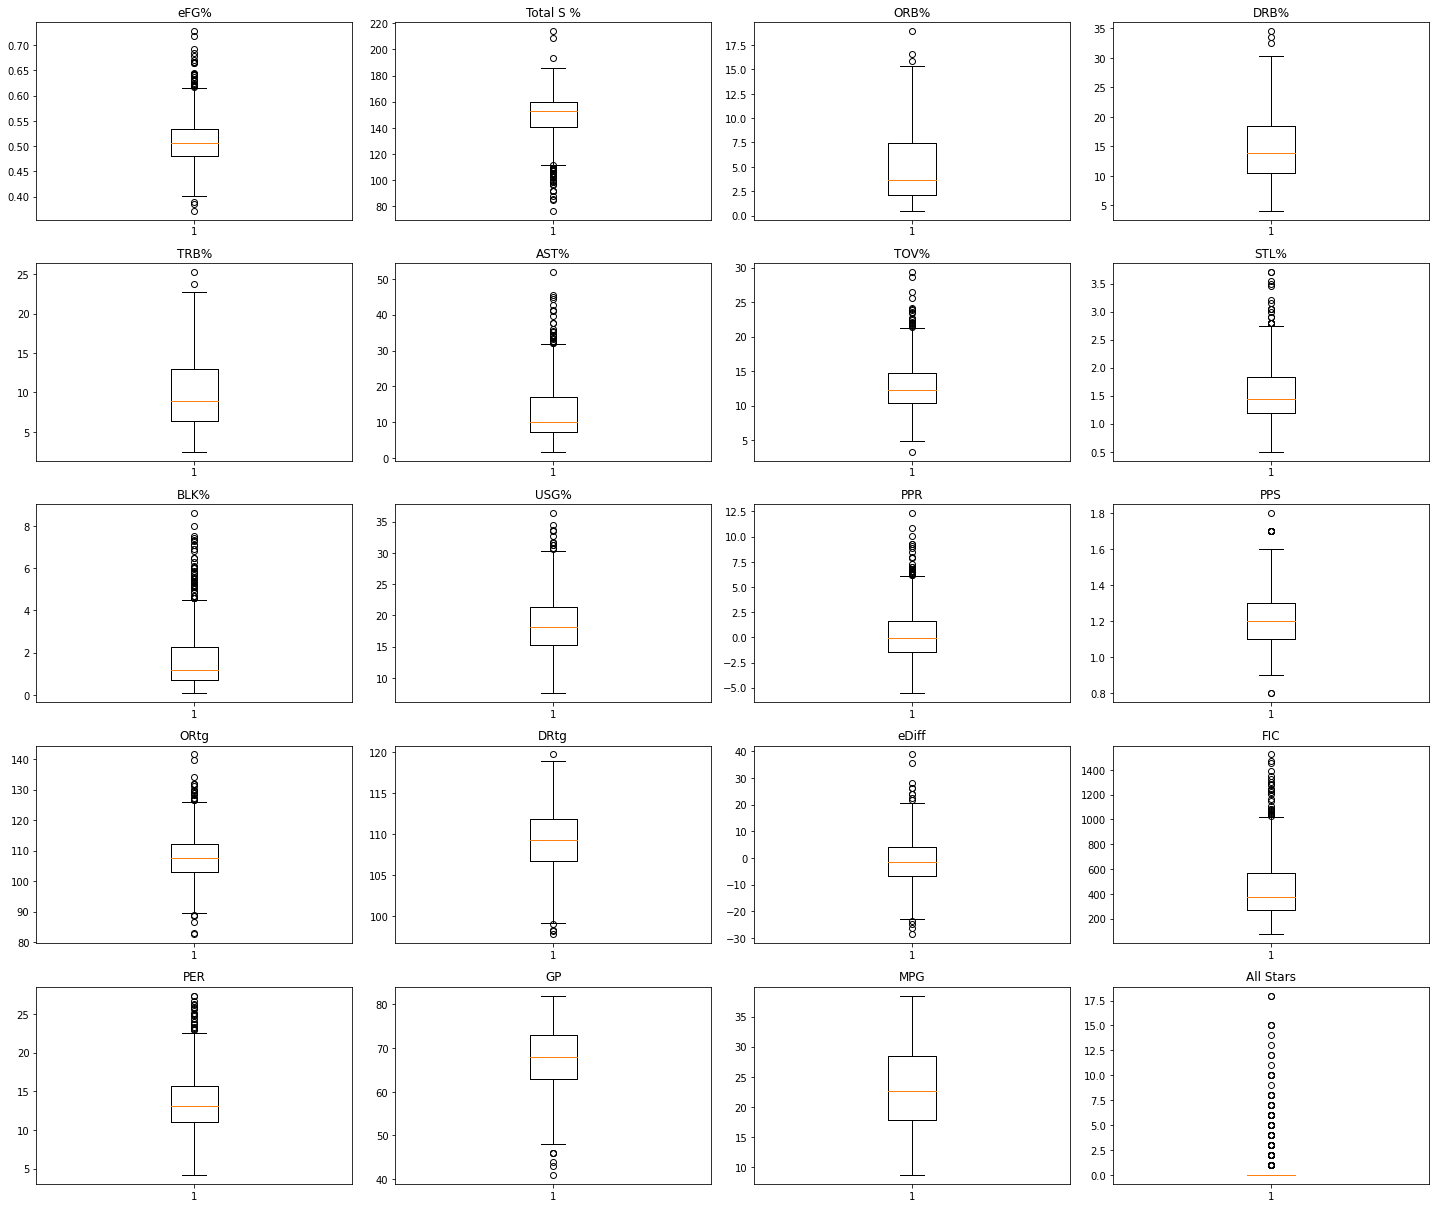

In [5]:
fig = plt.figure(figsize=(20, 20))
STATS = list(nba_adv_df.columns[2: ])
for i, stat in enumerate(STATS):
    plt.subplot(6, 4, i + 1)
    plt.boxplot(nba_adv_df[stat])
    plt.title(stat)
fig.tight_layout()
plt.show()

# PCA and Hierarchical Clustering

PCA was performed to reduce the numnber of dimensionby projecting each data point onto only the first few principal components tp obtain lower-dimensional data while preserving as much of the data's variation as possible. Using a PCA will allow us to see, which players have similar characteristics in terms of advanceded stats as players with similarities will be clusters closer togeher.

Additionally, a hierarchical analysis was performed used the principle component 1 (PC-1) and principle component 2 (PC-2) to determine what groups are formed between players. 

Finally, the stats based on the players will be used to determine if there are statistical differences between the different groups predicted and use that information to determine tiers with higher and lower caliber players. Using are own knowledge of NBA players, we will also look at the top 20 players from each tier to see if the groupings make sense.

## PCA

In [6]:
def generate_pca(df):
    """Generates a PCA and transforms the data based on the PCA.

    Keyword arguments:
    df -- data frame with NBA stats
    """
    from sklearn.preprocessing import StandardScaler
    from sklearn.decomposition import PCA
    scale = StandardScaler() # Scales the data so that one feature doesn't have more weight than another.
    scale.fit(df)
    df = pd.DataFrame(scale.transform(nba_adv_df[STATS]), columns=STATS)
    pca = PCA()
    pca.fit(df)
    transformed = pca.transform(df)
    return pca, np.array(transformed)

pca, x = generate_pca(nba_adv_df[STATS])
pca.explained_variance_ratio_[:5]

array([0.31220991, 0.21130101, 0.1213185 , 0.08713179, 0.05042744])

Principle components 1 and 2 were chosen for the hierarchical clustering anaylysis because they explained the highest amount of variance (54.4%).

## Hierarchical Clustering

Text(0.5, 0, 'Cluster Method')

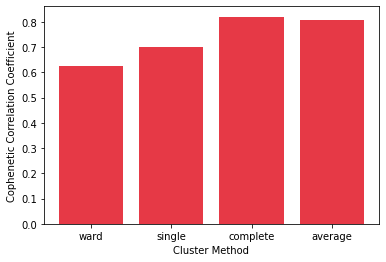

In [7]:
from scipy.cluster.hierarchy import cophenet, ward, single, complete, average
from scipy.spatial.distance import squareform, pdist

cluster_mthds = {"ward": ward, "single": single, "complete": complete, "average": average}

x_vals = []
y_vals = []
for key, value in cluster_mthds.items():
    x_vals.append(key)
    
    c, _ = cophenet(value(pdist(nba_adv_df[STATS])), pdist(nba_adv_df[STATS]))
    y_vals.append(c)

plt.bar(x=x_vals, height=y_vals, color="#e63946")
plt.ylabel("Cophenetic Correlation Coefficient")
plt.xlabel("Cluster Method")

# tmp = pd.DataFrame(squareform(d), index=nba_adv_df.Player, columns=nba_adv_df.Player)

In [8]:
y_vals

[0.6256750282263335, 0.7018154913028298, 0.819980788555906, 0.8077387558926687]

Complete linkage was chosen because it had the highest cophenetic correlation coefficicent.

In [9]:
CUTOFF_THRSHLD = 10
METHOD = "complete"
from scipy.cluster.hierarchy import linkage, leaves_list
from scipy.cluster.hierarchy import dendrogram

X_principal = pd.DataFrame({"P1": x[:, 0], "P2": x[:, 1]})
lnk = linkage(X_principal, method=METHOD, metric="euclidean")

### Group the trees together
from scipy.cluster.hierarchy import cut_tree
nba_adv_df["Group"] = cut_tree(lnk, height=CUTOFF_THRSHLD).flatten()
nba_adv_df["Group"] += 1

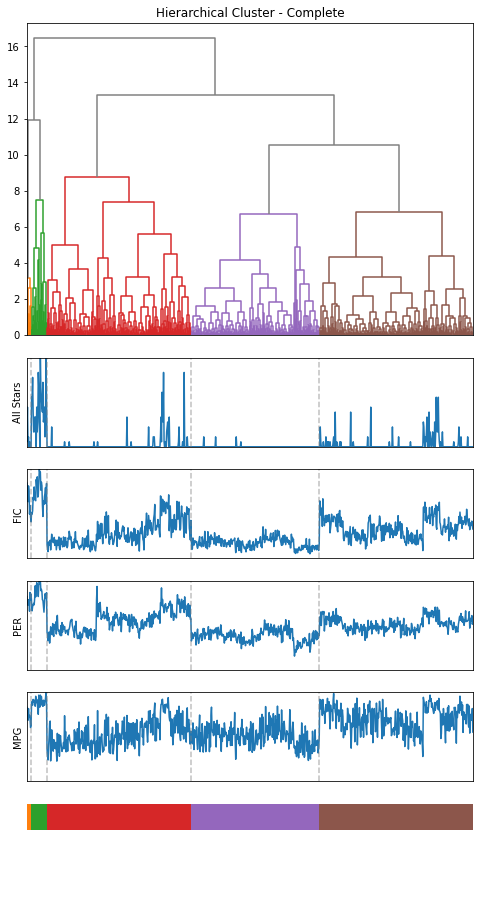

In [11]:
import matplotlib as mpl
from matplotlib.patches import Rectangle

fig = plt.figure(figsize=(8, 16))
gs = plt.GridSpec(8, 1, hspace=0.25)

fig.add_subplot(gs[:3,:])
dendo = dendrogram(lnk, color_threshold=CUTOFF_THRSHLD, above_threshold_color="grey", no_labels=True)
# plt.yticks([])

plt.title(f"Hierarchical Cluster - {METHOD.capitalize()}")

# Show Plot Line Graph of Interesting Stats
INTRST_STATS = ["All Stars","FIC", "PER", "MPG"]
leaves_ordered = nba_adv_df.iloc[leaves_list(lnk)]

start, end = 3, 4

#Plot Labels
grp_lst = np.array(dendo["leaves_color_list"])
labels = np.unique(grp_lst)

for stat in INTRST_STATS:
    ax = fig.add_subplot(gs[start:end,0], xticklabels=[], yticklabels=[])
    ax.plot(list(leaves_ordered[stat]))
    ax.yaxis.tick_right()
    ax.yaxis.label_position
    plt.ylabel(stat)
    plt.xlim([min(leaves_ordered.index), max(leaves_ordered.index)])
    y_max = max(list(leaves_ordered[stat]))
    plt.ylim(0,y_max)
    plt.tick_params(bottom=False, right=False)
    
    #add an Hline to each stat of interest
    for i in range(len(labels) - 1):
        loc = max(np.where(grp_lst == labels[i])[0])
        plt.vlines(loc, ymin=0, ymax=2000, colors="grey", linestyles="dashed", alpha=0.5)
    
    # Add plot to next row of grid
    start = end
    end += 1
    
###### Adding Labels to bottom of the figure #################
ax = fig.add_subplot(gs[start:end,0])
# Draws the xaxis
plt.xlim([min(leaves_ordered.index), max(leaves_ordered.index)])
plt.ylim(0, 10)

# Hide the frame for the plot
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.get_xaxis().set_ticks([])
ax.get_yaxis().set_ticks([])


# Add rectangle labels
i = len(labels) - 1
while i >= 0:
    lbl = labels[i]
    box_len = max(np.where(grp_lst == lbl)[0])
    box_start = min(np.where(grp_lst == lbl)[0])
    i-=1
    ax.add_patch(Rectangle((0, 7), box_len, 5, facecolor=lbl))
    
#     plt.text((box_start + box_len - 10) // 2, 8, lbl, color = "white")

plt.tick_params(bottom=False, right=False)
# plt.savefig(f'./figures/dendogram_{METHOD}', bbox_inches='tight')
plt.show()

Based on the above figure, it appears that there are 5 different groups (groups found empirically). When looking at the groups, we see that C2 and C3 appear to players with allstar experience, FIC, and PER. Since these groups contain more all star players and players with higher impact on game outcomes(FIC and PER), these should be consider are highest tier players. While group C4 seems to be lowest tier group as they play fewer minutes and have the least amount of impactful players. Groups C1 and C5 maybe mid-tier players as the still contribute to the game and some players make the allstar team.

In [12]:
num_K = max(nba_adv_df["Group"])
nba_adv_df["Colors"] = None
nba_adv_df.Colors.iloc[leaves_list(lnk)] = dendo["leaves_color_list"]
colors_order = nba_adv_df.groupby("Colors").median().sort_values(by="PER", ascending=False).index

group_labels = {}
for i,color in enumerate(colors_order):
    group_labels[color] = f"C{i + 1}"

/var/folders/98/l_64__1s7yl7t4kxht7j0bzw0000gn/T/ipykernel_42278/2400117624.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nba_adv_df.Colors.iloc[leaves_list(lnk)] = dendo["leaves_color_list"]


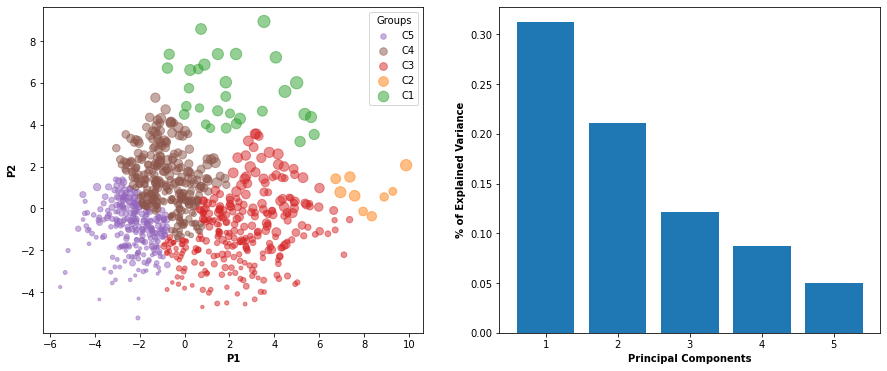

In [13]:

def plot_pca(pca, expl_var,stats_df, num_K, highlight=None, numPlayersShown=10, adjSize=0.1):
    plt.figure(figsize =(15, 6))
    groups = np.unique(stats_df.Group)
  
    plt.subplot(1,2,1)
    for group in groups:
        pca_group = pca.loc[list(np.where(nba_adv_df["Group"] == group)[0])]
        
        c = stats_df[stats_df["Group"] == group]["Colors"].unique()[0]
        x, y = pca_group['P1'], pca_group['P2']
        index = list(np.where(stats_df["Group"] == group)[0])
       
        if highlight:
            s = stats_df[highlight].iloc[index] * adjSize
            plt.scatter(x, y, alpha=0.5, label=group_labels[c], s=s, c=c)
            
        else:
            plt.scatter(x, y, alpha=0.5, label=group_labels[c], c=c)
    
    plt.xlabel("P1", fontweight="bold")
    plt.ylabel("P2", fontweight="bold")
    plt.legend(title="Groups")       
    
    # Scree Plot
    plt.subplot(1,2,2)
    plt.bar([i + 1 for i in range(len(expl_var))], expl_var)
    plt.xlabel("Principal Components", fontweight="bold")
    plt.ylabel("% of Explained Variance", fontweight="bold")
#     plt.savefig(f'./figures/pca')
    plt.show()

expl_var = pca.explained_variance_ratio_[:5]
plot_pca(X_principal, expl_var, nba_adv_df, num_K=num_K, highlight="FIC", adjSize=0.1)


Colors based on hierarchical clusters and size of circles represent each players FIC score. This graph again shows that players a tend to be in C3 and C2 contribute more to a game than C4, which typically have the lowest FICs.

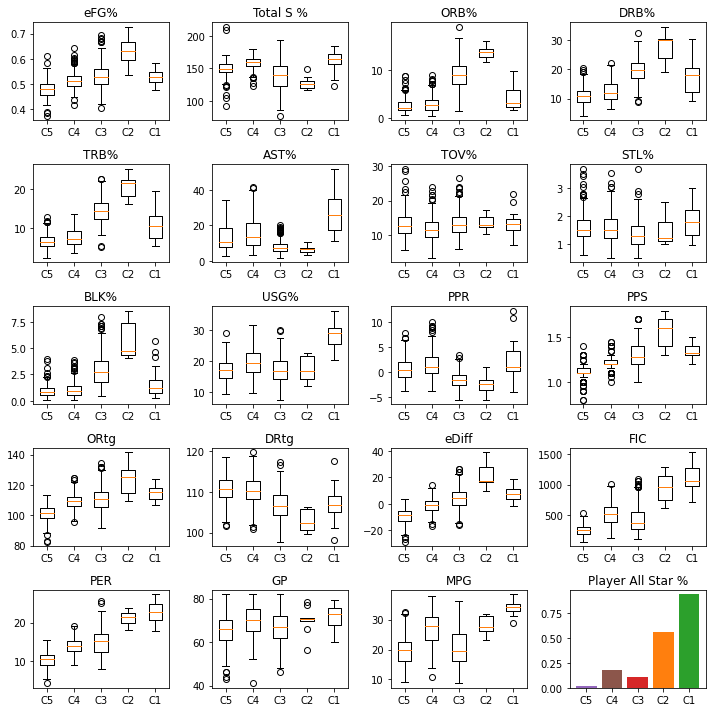

In [15]:

fig = plt.figure(figsize=(10, 10))
for i, stat in enumerate(STATS):
    
    plt.subplot(5, 4, i + 1)
    grp, res =[], []
    
    groups = np.unique(nba_adv_df.Group)
    colors = []
    for group in groups:
        color = nba_adv_df[nba_adv_df.Group == group]["Colors"]
        color = np.unique(color)[0]
        colors.append(color)

        toGraph = nba_adv_df[nba_adv_df["Group"] == group]
        toGraph = toGraph[stat]
        res.append(toGraph)
        
        if stat == "All Stars":
            total = len(toGraph)
            num_stars = np.count_nonzero(toGraph)
            height = num_stars/total
            plt.bar(group, height, color=color)
            plt.title("Player All Star %")
    
    
    if stat != "All Stars":
        plt.boxplot(res) 
        plt.title(stat)

    
    plt.xticks([i for i in range(1, len(groups) + 1)], [group_labels[c] for c in colors])
    
fig.tight_layout()
# plt.savefig(f'./figures/group_stats')
plt.show()

This figure further confirms differences in between tiers of players. For example players C2 and C3 tend to have more all star players, play more minutes (MPG), have higher player efficiency (PER), and Floor Impact Counter (FIC). While groups C1 and C5 don't have many allstar players they do tend to player more minutes per game (MPG) and they both have a higher median PER and FIC in comparision to C4. Therefore, it is reasonable to consider these players to be mid-tier players (stars), which can still have an impact on the game. Finally, C4 is the low tier or bench players, which do get some playing time, but don't contribute much to the game.

In [16]:
sortBy = "PER"

print(f"Top Players for each cluster based on {sortBy}")
for key, tier in group_labels.items():

    print("*"* 50, end="\n\n")
    print(tier)
    print(list(nba_adv_df[nba_adv_df.Colors == key].sort_values(by=sortBy, ascending=False)[:20].Player))
    print()

Top Players for each cluster based on PER
**************************************************

C1
['LeBron James', 'Giannis Antetokounmpo', 'Anthony Davis', 'Nikola Jokic', 'Kevin Durant', 'Joel Embiid', 'Kawhi Leonard', 'Luka Doncic', 'Karl-Anthony Towns', 'James Harden', 'Chris Paul', 'Stephen Curry', 'Russell Westbrook', 'Trae Young', 'Damian Lillard', 'Tim Duncan', 'Jimmy Butler', 'Blake Griffin', 'Kobe Bryant', 'Kyrie Irving']

**************************************************

C2
['Hassan Whiteside', 'Robert Williams', 'Rudy Gobert', 'Andre Drummond', 'Clint Capela', 'Mitchell Robinson', 'Dwight Howard', 'Jarrett Allen', 'DeAndre Jordan']

**************************************************

C3
['Boban Marjanovic', 'Zion Williamson', 'Montrezl Harrell', 'Enes Freedom', 'DeMarcus Cousins', 'Jonas Valanciunas', 'LaMarcus Aldridge', 'Daniel Gafford', 'Brandan Wright', 'Greg Monroe', 'Thomas Bryant', 'Brandon Clarke', 'Andrew Bynum', 'Chris Boucher', 'Tony Bradley', 'Domantas Sabonis'

When looking at the top 20 players based on PER:
* we see that most players from C3, have been in conversation for MVP of the league and have regularly made allstar appearnces.
* C2 has some players that have had thier names mentioned for MVP and some even making MVP, but still not as many as C3. Additionally, a lot of these players are solod starters and have even made a few all star appearances.
* C4 all seem to be players that have mostly a bench role and many I haven't heard of.
* Finally, C1 and C5 definitely have some respectible players in the league that teams look to add for solid starters and depth. Some have even had a few allstar appearances.

# Write nba_adv_df to CSV

In [17]:
# tiers = { "C1": 2, "C2": 1, "C3": 4, "C4": 5, "C5": 3,}
nba_adv_df.replace({"Colors":colors_order}, inplace=True)
nba_adv_df.iloc[:, :-1].to_csv("./data/nba_adv_tiers.csv", index=False)